In [1]:
# laod the pred boxes of each model
import json
import os
import numpy as np

# load the ultralytics models pred boxes
ultralytics_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "ultralytics_models_pred_boxes_result_22_05_2024.json")
detectron2_models_pred_boxes_saveing_path = os.path.join("/home/etaylor/code_projects/thesis/data/models_scores", "detectron2_models_pred_boxes_result_22_05_2024.json")

with open(ultralytics_models_pred_boxes_saveing_path, "r") as f:
    ultralytics_models_pred_boxes = json.load(f)
    
with open(detectron2_models_pred_boxes_saveing_path, "r") as f:
    detectron2_models_pred_boxes = json.load(f)

In [2]:
from src.segmentation.evaluation.detectron2_evaluator import Detectron2Evaluator
import os

# varaiables
dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44"
images_dir_path = os.path.join(dataset_path, "v0.1")
coco_annotations_path = os.path.join(dataset_path, "annotations", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json")
yolo_annotations_dir_path = os.path.join(dataset_path, "annotations", "yolo", "labels", "export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1")

# get evalutor and get the ground truth boxes
detectron2_evaluator = Detectron2Evaluator(num_classes=3,coco_annotations_file_path=coco_annotations_path)
dataset_gt_boxes = detectron2_evaluator.get_annotations_for_dataset(images_directory=images_dir_path)

In [13]:
all_models_pred_boxes = {**ultralytics_models_pred_boxes, **detectron2_models_pred_boxes}

In [14]:
models_eval_results = {}
for model_name, pred_boxes in all_models_pred_boxes.items():
    print(f"evaluating model: {model_name}")
    eval_results = detectron2_evaluator.evaluate_dataset(dataset_pred_boxes_dict=pred_boxes,
                                                            dataset_gt_boxes_dict=dataset_gt_boxes,
                                                            single_class=True)
    models_eval_results[model_name] = eval_results

evaluating model: rtdetr_x
evaluating model: yolov5xu
evaluating model: yolov8x
evaluating model: yolov9c
evaluating model: mask_rcnn_R_50_FPN_3x
evaluating model: mask_rcnn_X_101_32x8d_FPN_3x
evaluating model: faster_rcnn_R_50_C4_1x
evaluating model: faster_rcnn_R_50_DC5_1x


### Plot the results

In [35]:

import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_results(combined_results, iou_threshold):
    """
    Plots various metrics and confusion matrices from the combined evaluation results for a given IoU threshold.

    Args:
        combined_results (dict): Dictionary containing evaluation results for various models.
        iou_threshold (float): The IoU threshold used for the evaluation.
    """
    # Plotting bar metrics
    fig1, axes1 = plt.subplots(2, 2, figsize=(20, 12))
    fig1.suptitle(f'Evaluation Results for IoU Threshold {iou_threshold}', fontsize=16)

    plot_metric_bar(combined_results, 'precision', 'Precision', iou_threshold, ax=axes1[0, 0])
    plot_metric_bar(combined_results, 'recall', 'Recall', iou_threshold, ax=axes1[0, 1])
    plot_metric_bar(combined_results, 'class_wise_precision', 'Class-wise Precision', iou_threshold, ax=axes1[1, 0])
    plot_metric_bar(combined_results, 'class_wise_recall', 'Class-wise Recall', iou_threshold, ax=axes1[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting confusion matrices
    num_models = len(combined_results)
    fig2, axes2 = plt.subplots(2, num_models, figsize=(20, 12))
    fig2.suptitle(f'Confusion Matrices for IoU Threshold {iou_threshold}', fontsize=16)

    for idx, (model, results) in enumerate(combined_results.items()):
        plot_single_confusion_matrix(results, model, False, iou_threshold, ax=axes2[0, idx])
        plot_single_confusion_matrix(results, model, True, iou_threshold, ax=axes2[1, idx])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_metric_bar(models_results, metric_name, ylabel, iou_threshold, ax=None):
    labels = list(models_results.keys())
    values = [results['metrics'][metric_name] for results in models_results.values()]
    
    if isinstance(values[0], list) or isinstance(values[0], np.ndarray):
        x = np.arange(len(labels))
        width = 0.2  # Width of the bars
        num_classes = len(values[0])
        for i in range(num_classes):
            class_values = [v[i] for v in values]
            ax.bar(x + i * width, class_values, width, label=f'Class {i+1}')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x + width * (num_classes - 1) / 2)
        ax.set_xticklabels(labels)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    else:
        x = np.arange(len(labels))
        ax.bar(x, values, width=0.5, color='blue')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} for different models (IoU={iou_threshold})')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

def plot_single_confusion_matrix(results, model, normalized, iou_threshold, ax=None):
    if normalized:
        matrix = np.array(results['normalized_confusion_matrix'])
        title = model
        fmt = '.2f'
    else:
        matrix = np.array(results['confusion_matrix'])
        title = model
        fmt = 'd'

    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(matrix))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(tick_marks, rotation=45)
    ax.set_yticklabels(tick_marks)
    
    thresh = matrix.max() / 2.
    for i, j in np.ndindex(matrix.shape):
        ax.text(j, i, format(matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if matrix[i, j] > thresh else "black")
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


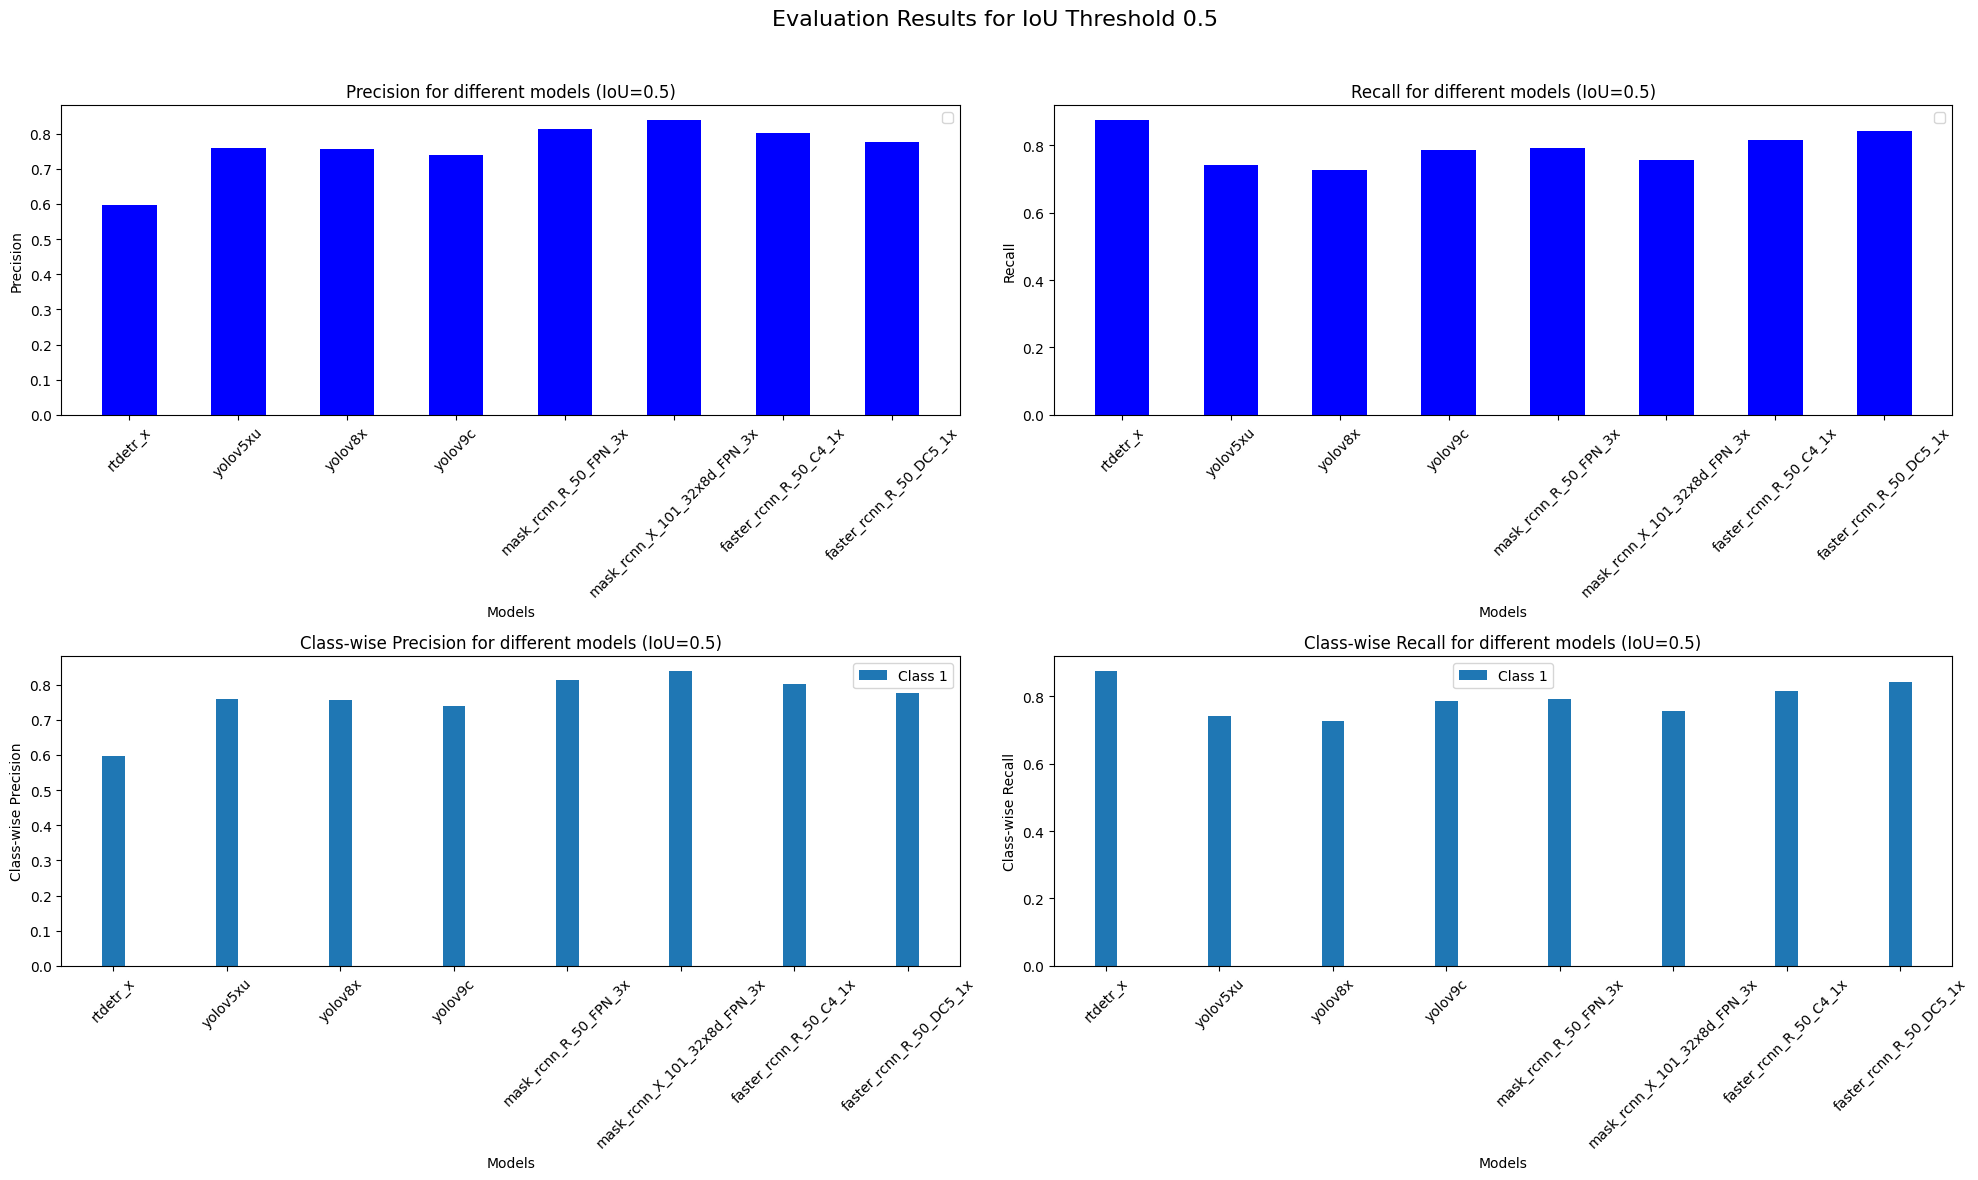

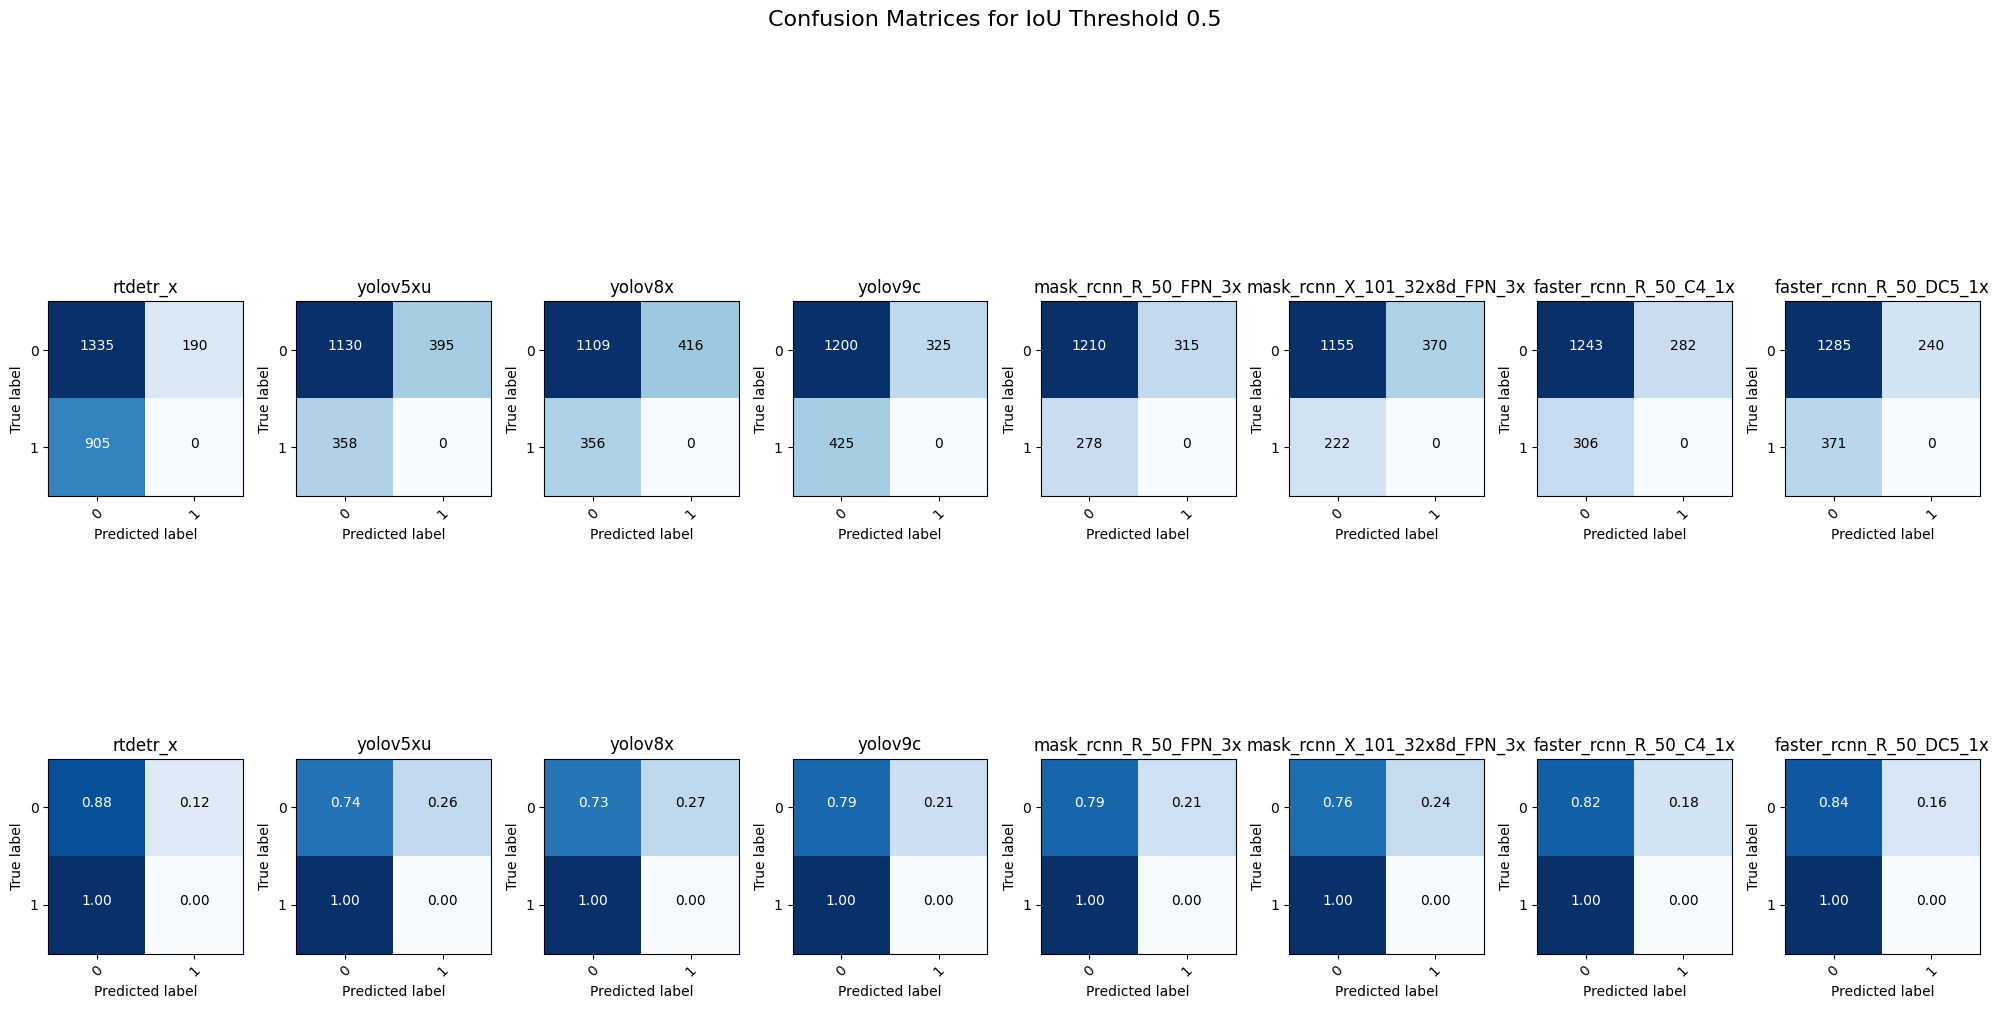

In [36]:
plot_evaluation_results(models_eval_results, iou_threshold=0.5)